In [1]:
"""
    当下的思路是先使用01 来对数据进行stdp预训练，训练的结果要满足对01数据可以达到比较好的分类

    进而切换到更多数据，比如加入"5", 这里假设认为5 归属于1， 那么需要设计网络的权重更新，使得5

    对应的脉冲输出可以不断的替代掉老的数据， 这里总感觉有一个buffer 的含义，

    并且，对真实交互的数据的重要性要进行方法，这里可以体现在，reward上，也可以体现在 buffer的统计上

    感觉本质上还是一个特征提取的操作

    如果只使用原来的算法，很可能最开始的预训练的速度很慢，可以想办法加快一点，对stdp进行修改

    1的脉冲次数 要小于0的次数很多， 这里怀疑可能跟 1 的图像面积小有关系

    这里的面积的大小与出现的次数还没有关系
"""
import collections
import numpy as np
from tqdm import tqdm
import os
import random
import torch
from SPAIC import spaic
import torch.nn.functional as F
from SPAIC.spaic.Learning.Learner import Learner
from SPAIC.spaic.Library.Network_saver import network_save
from SPAIC.spaic.Library.Network_loader import network_load
from SPAIC.spaic.IO.Dataset import MNIST as dataset
from SPAIC.spaic.IO.Dataset import CUSTOM_MNIST, NEW_DATA_MNIST
import gymnasium as gym
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


In [2]:
root = './SPAIC/spaic/Datasets/MNIST'
train_set = CUSTOM_MNIST(root, is_train=True) # 这里加一个mast 只要01
test_set =CUSTOM_MNIST(root, is_train=False)
new_data_set = NEW_DATA_MNIST(root, is_train=False) # 引入新的数据 包括012

bat_size = 1

>> Dataset loaded
>> Dataset loaded
>> Dataset loaded


In [3]:
train_loader = spaic.Dataloader(train_set, batch_size=bat_size, shuffle=False, drop_last=False)
test_loader = spaic.Dataloader(test_set, batch_size=bat_size, shuffle=False)
newdata_loader = spaic.Dataloader(new_data_set,batch_size=bat_size,shuffle=False)


In [5]:
for item in train_loader:
    
    break

In [ ]:
print(item[0])

In [ ]:
print(train_set[0])

In [43]:
x = np.random.random(100)
x

array([0.26543871, 0.56587902, 0.53825798, 0.90862034, 0.71504235,
       0.5880594 , 0.62244346, 0.77124955, 0.73985895, 0.35852957,
       0.71185579, 0.60230688, 0.31650957, 0.67672722, 0.40558294,
       0.59454676, 0.20748977, 0.58538088, 0.6490081 , 0.18668795,
       0.48354343, 0.80705988, 0.62855592, 0.64780359, 0.69005911,
       0.51678862, 0.10753095, 0.03989409, 0.60927744, 0.71455079,
       0.92245013, 0.53696965, 0.40068297, 0.1850092 , 0.68258789,
       0.6207409 , 0.79425662, 0.3213633 , 0.15865056, 0.531202  ,
       0.85401306, 0.442592  , 0.40195508, 0.96248615, 0.60654813,
       0.34611665, 0.44991862, 0.7712703 , 0.06932742, 0.19743216,
       0.06334737, 0.48580846, 0.19664752, 0.77180039, 0.33516739,
       0.52941168, 0.77561714, 0.2005362 , 0.13742824, 0.80276477,
       0.15220107, 0.63844156, 0.74756494, 0.83626556, 0.20698073,
       0.67415461, 0.30667296, 0.77835309, 0.02314221, 0.53898921,
       0.65391384, 0.28070221, 0.07664592, 0.52891707, 0.79307

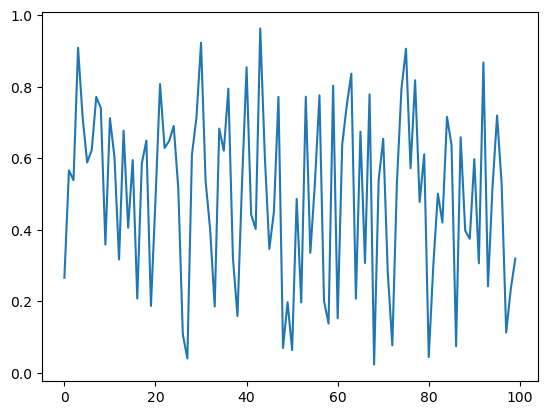

In [44]:
plt.plot(x)

In [45]:
y = x * 10 / np.sum(x)
y

array([0.05309378, 0.11318868, 0.10766384, 0.18174474, 0.14302474,
       0.11762526, 0.12450285, 0.15426746, 0.14798862, 0.07171407,
       0.14238735, 0.12047508, 0.06330912, 0.13536084, 0.08112582,
       0.11892288, 0.04150267, 0.1170895 , 0.12981639, 0.03734184,
       0.09671969, 0.16143034, 0.12572549, 0.12957546, 0.13802752,
       0.10336948, 0.02150864, 0.00797973, 0.12186935, 0.14292642,
       0.18451101, 0.10740615, 0.08014571, 0.03700605, 0.13653311,
       0.1241623 , 0.15886939, 0.06427997, 0.03173372, 0.10625249,
       0.17082204, 0.08852847, 0.08040016, 0.19251913, 0.12132343,
       0.0692312 , 0.08999396, 0.15427161, 0.01386706, 0.03949092,
       0.01267092, 0.09717274, 0.03933398, 0.15437764, 0.0670411 ,
       0.10589438, 0.15514108, 0.0401118 , 0.02748877, 0.16057122,
       0.03044368, 0.12770284, 0.14953   , 0.16727214, 0.04140086,
       0.13484626, 0.06134157, 0.15568833, 0.00462897, 0.10781011,
       0.13079765, 0.05614683, 0.01533093, 0.10579545, 0.15863

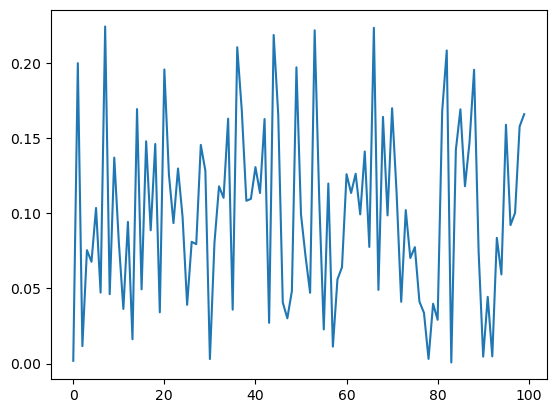

In [42]:
plt.plot(y)

In [46]:
torch.sum(torch.rand(2,4), dim=1, keepdim=True)

tensor([[1.5512],
        [1.7149]])

In [4]:
np.random.random([1,4])

array([[0.88437646, 0.30125101, 0.72440553, 0.00489184]])

In [47]:
a = torch.load('a.pth')
b = torch.load('b.pth')

In [48]:
a

tensor([[0.1672, 0.0160, 0.0462,  ..., 0.5335, 0.8372, 0.3045],
        [0.4961, 0.3797, 0.2362,  ..., 0.4432, 0.8387, 0.4335],
        [0.4325, 0.6042, 0.5557,  ..., 0.2787, 0.6614, 0.5520],
        ...,
        [0.0015, 0.5178, 0.4156,  ..., 0.7309, 0.7872, 0.0088],
        [0.8091, 0.4486, 0.3607,  ..., 0.3181, 0.2291, 0.3606],
        [0.6958, 0.9486, 0.0097,  ..., 0.9234, 0.1210, 0.1722]],
       device='cuda:0', requires_grad=True)

In [49]:
b

tensor([[0.1672, 0.0160, 0.0462,  ..., 0.5335, 0.8372, 0.3045],
        [0.4961, 0.3797, 0.2362,  ..., 0.4432, 0.8387, 0.4335],
        [0.4325, 0.6042, 0.5557,  ..., 0.2787, 0.6614, 0.5520],
        ...,
        [0.0015, 0.5178, 0.4156,  ..., 0.7309, 0.7872, 0.0088],
        [0.8091, 0.4486, 0.3607,  ..., 0.3181, 0.2291, 0.3606],
        [0.6958, 0.9486, 0.0097,  ..., 0.9234, 0.1210, 0.1722]],
       device='cuda:0', requires_grad=True)

In [55]:
for i in range(len(a)):
    print(i, " ", torch.all(a[i]==b[i]))

0   tensor(True, device='cuda:0')
1   tensor(True, device='cuda:0')
2   tensor(True, device='cuda:0')
3   tensor(True, device='cuda:0')
4   tensor(True, device='cuda:0')
5   tensor(True, device='cuda:0')
6   tensor(True, device='cuda:0')
7   tensor(True, device='cuda:0')
8   tensor(False, device='cuda:0')
9   tensor(True, device='cuda:0')
10   tensor(True, device='cuda:0')
11   tensor(True, device='cuda:0')
12   tensor(True, device='cuda:0')
13   tensor(True, device='cuda:0')
14   tensor(True, device='cuda:0')
15   tensor(True, device='cuda:0')
16   tensor(True, device='cuda:0')
17   tensor(True, device='cuda:0')
18   tensor(True, device='cuda:0')
19   tensor(True, device='cuda:0')
20   tensor(True, device='cuda:0')
21   tensor(True, device='cuda:0')
22   tensor(True, device='cuda:0')
23   tensor(True, device='cuda:0')
24   tensor(True, device='cuda:0')
25   tensor(True, device='cuda:0')
26   tensor(True, device='cuda:0')
27   tensor(True, device='cuda:0')
28   tensor(False, device='cu

In [71]:
a[28][0]-b[28][0]

tensor(1.1921e-07, device='cuda:0', grad_fn=<SubBackward0>)

In [69]:
b[28][0]

tensor(0.8008, device='cuda:0', grad_fn=<SelectBackward0>)

In [12]:
print(buffer[0][8])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], device='cuda:0')


In [72]:
_buffer = torch.load('cobot_buffer.pth')


In [88]:
sum(_buffer[0])

tensor([[ 0.,  8., 60., 42.,  4., 56.,  0., 81., 67.,  0.,  1., 75., 37., 19.,
          0., 10., 49., 69.,  7.,  0., 71., 62.,  0.,  0., 67., 61., 25., 75.,
          0.,  0., 24., 13.,  0., 20., 75., 79., 78.,  0., 72., 81., 74., 18.,
          0.,  2.,  0., 78.,  0.,  4., 59., 68., 74.,  3., 25., 28., 25.,  8.,
         70., 81.,  3.,  3.,  2., 81., 74., 81.,  0.,  0., 39., 24., 53.,  0.,
         32.,  1., 64., 12., 15., 57., 75., 70., 25., 43.,  2., 76.,  0.,  0.,
          1., 74.,  6.,  0., 20.,  3., 70., 73., 55.,  5., 74., 67.,  9., 72.,
         12., 50.]], device='cuda:0')

In [32]:
a = np.random.random(4)
print(type(np.array([a])))

<class 'numpy.ndarray'>


In [33]:
a = [1,2,3,4]
print(type(np.array([a])))

<class 'numpy.ndarray'>


In [34]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:

log_path = './log/test2'
writer = SummaryWriter(log_path)

for file in os.listdir(log_path):
    os.remove(log_path + '/' + file) # 把和上一次的log清空

# tensorboard.exe --logdir=./log/episode_reward

root = './SPAIC/spaic/Datasets/MNIST'
train_set = CUSTOM_MNIST(root, is_train=True) # 这里加一个mast 只要01
test_set =CUSTOM_MNIST(root, is_train=False)
new_data_set = NEW_DATA_MNIST(root, is_train=False) # 引入新的数据 包括012
device = torch.device("cuda")


node_num = 784
label_num = 100 # 这里要不了这么多

bat_size = 1


train_loader = spaic.Dataloader(train_set, batch_size=bat_size, shuffle=False, drop_last=False)
test_loader = spaic.Dataloader(test_set, batch_size=bat_size, shuffle=False)
newdata_loader = spaic.Dataloader(new_data_set,batch_size=bat_size,shuffle=False)

backend = spaic.Torch_Backend(device)
backend.dt = 0.1
run_time = 256 * backend.dt 

time_step = int(run_time / backend.dt)

lr = 0.001 # stdp暂时不用学习率， 真实的学习率应该是体现在算法里面了

In [7]:


class TestNet(spaic.Network):
    def __init__(self):
        super().__init__()

        self.input = spaic.Encoder(num=node_num, time=run_time, coding_method='poisson', unit_conversion=0.6375) # 就是给发放速率乘了因子,from 论文

        self.layer1 = spaic.NeuronGroup(label_num, model='lifstdp_ex') # stdp_ex 比 stdp_ih 多了一层阈值的衰减 \tao_\theta, 论文中有提到这个自适应的阈值
        
        self.layer2 = spaic.NeuronGroup(label_num, model='lifstdp_ih') # 维度都是100， 

        self.output = spaic.Decoder(num=label_num, dec_target=self.layer1, time=run_time, coding_method='spike_counts') # layer1作为了输出层, 兴奋次数作为输出

        self.connection1 = spaic.Connection(self.input, self.layer1, link_type='full', weight=(np.random.rand(label_num, 784) * 0.3)) # 100 * 784
        
        self.connection2 = spaic.Connection(self.layer1, self.layer2, link_type='full', weight=np.diag(np.ones(label_num)) * 22.5   )
        
        self.connection3 = spaic.Connection(self.layer2, self.layer1, link_type='full', weight=( np.ones((label_num, label_num)) - np.diag(np.ones(label_num)) ) * (-120)) # 起到一个抑制的作用，除了1-1的前一个，侧向抑制，并起到竞争的效果

        self._learner = Learner(algorithm='nearest_online_stdp', trainable=self.connection1, run_time=run_time) # 这里也只是训练 从输入到第一层的连接，其余层不变

        self.reward = spaic.Reward(num=label_num, dec_target=self.layer1, coding_time=run_time, coding_method='environment_reward', dec_sample_step=1) # 采样频率是每个时间步一次
        #
        self.mon_weight = spaic.StateMonitor(self.connection1, 'weight', nbatch=-1)
        
        self.set_backend(backend)

        self.buffer = [[],[]] # 0, 1 投票神经元的buffer

        self.assign_label = None

    def step(self, data, reward=1):

        self.input(data) # 输入数据

        self.reward(1) # 这里1，rstdp 退化为stdp 输入奖励 0 则不更新权重

        self.run(run_time) # 前向传播

        return self.output.predict # 输出 结果

In [8]:
agent = TestNet() # 这里如果一个网络 不行，也可以考虑使用第二个网络进行辅助？

im = None

file_name = 'save/testidea' # 权重的保存文件
buffer_name = 'buffer.pth' # buffer的保存文件

train_num = 1000 # 800次的时候可以达到0.65的成功率 这里应该想办法怎么既能减小 训练次数又能 增大预训练的效率

def TestNet_Init(flag='train'):
    """
        这个函数完成对0 1数据的初始化操作， 也就是希望网路可以达到对0 1的初步分类作用
        可以的话，最好把权重也保存一下，下次再使用的时候就不用再次训练了
    """
    global im
    if flag =='train':

        print("开始预训练")
        for episode in range(1):
            pbar = tqdm(total=len(train_loader))

            for i, item in enumerate(train_loader):
                data, label = item
                output = agent.step(data)

                agent.buffer[label[0]].append(output) # label[0]的第一个维度是batch
                im = agent.mon_weight.plot_weight(time_id=-1, linewidths=0, linecolor='white',
                            reshape=True, n_sqrt=int(np.sqrt(label_num)), side=28, im=im, wmax=1) #把权重 画出来 100 * 784 = 100 * 28 * 28
                pbar.update()
                if i > train_num:
                    break #   
        # network_save(Net=agent,filename='saveidea',save_weight=True)

        agent.save_state(filename=file_name) # 这里需要手动删除保存的文件夹
        torch.save(agent.buffer, buffer_name) # buffer 也需要保存起来

    elif flag == 'load':
        print("加载预训练数据和buffer")
        agent.state_from_dict(filename=file_name, device=device)
        agent.buffer = torch.load(buffer_name)

    assign_label_update() 
    

In [9]:
def assign_label_update(newoutput=None, newlabel=None, weight=0):
    # 如果没有新的数据输入，则就是对 assign_label 进行一次计算，否则 会根据权重插入新数据，进而计算
    if newoutput != None:
        agent.buffer[newlabel].append(newoutput)
    avg_buffer = [sum(agent.buffer[i]) / len(agent.buffer[i]) for i in range(len(agent.buffer))] # sum_buffer 是一个求和之后 取平均的tensor  n * 1 * 100
    # avg_buffer = [sum_buffer[i] / len(agent.buffer[i]) for i in range(len(agent.buffer))]
    assign_label = torch.argmax(torch.cat(avg_buffer, 0), 0) # n 个1*100 的list在第0个维度合并 -> n*100的tensor, 进而在第0个维度比哪个更大, 返回一个1维的tensor， 内容是index，0-n， 目前是0和1
    # 这里的 100 个 0 和1 也就代表了， 当前那个神经元 可以代表的 类别是什么
    agent.assign_label = assign_label # 初始化结束


In [10]:

eval_acc = []
def TestNet_Eval(eval_num=1000):
    # 这里测试一下对0和1的准确率
    global im
    right_predict = 0
    
    print("开始预测")

    with torch.no_grad(): # 这里存粹的测试，不会更新权重 没有 drop层 所以与使用 eval 是一样的效果
        pbar = tqdm(total=len(test_loader))
        for index, item in enumerate(test_loader):
            data, label = item
            output = agent.step(data)
        
            temp_cnt = [0 for _ in range(len(agent.buffer))]
            # 这里的每一个输出[1,2,3,4,5...], 就像是在投票，由于每一个位置类别已经确定，现在，只需要把每个类别的投票的总次数加起来，即可
            for i in range(len(agent.assign_label)):
                temp_cnt[agent.assign_label[i]] += output[0, i] # 第一个维度是batch, 

            predict_label = torch.argmax(torch.tensor(temp_cnt))
            # print("... ", label, predict_label)
            if label[0] == predict_label:
                right_predict += 1
            eval_acc.append(right_predict / (1+index))
            if index > eval_num:
                break
            pbar.update()
    print(" 总数为：", eval_num+2 ," 预测成功为：",right_predict)
    plt.plot(eval_acc)
    plt.show()

In [17]:

nd_eval_acc = []

right_predict = 0
def ND_TestNet_Eval_And_Train(nd_eval_num = 1000):
    # 从这里开始增加2 作为新数据，并把2 归属与 1 的label
    global im, right_predict
    
    
    print("新数据集测试与微调")

    pbar = tqdm(total=len(newdata_loader))
    for index, item in enumerate(newdata_loader):
        
        data, label = item
        print(label)
        if label[0] != 0:
            label[0] = 1 # 把2 也归为1
        output = agent.step(data)
        im = agent.mon_weight.plot_weight(time_id=-1, linewidths=0, linecolor='white',
                            reshape=True, n_sqrt=int(np.sqrt(label_num)), side=28, im=im, wmax=1) #把权重 画出来 100 * 784 = 100 * 28 * 28

        temp_cnt = [0 for _ in range(len(agent.buffer))]
        # 这里的每一个输出[1,2,3,4,5...], 就像是在投票，由于每一个位置类别已经确定，现在，只需要把每个类别的投票的总次数加起来，即可
        for i in range(len(agent.assign_label)):
            temp_cnt[agent.assign_label[i]] += output[0, i] # 第一个维度是batch, 

        predict_label = torch.argmax(torch.tensor(temp_cnt))
        # print("... ", label, predict_label)
        if label[0] == predict_label:
            right_predict += 1

        # 这里要使用真实标签对数据对投票集进行补充或修改
        assign_label_update(output, label[0], weight=0) # 权重的体现，可以是乘在output上，也可以是 copy n个插入buffer
        # 预测正确和错误也可以 不断调整 更新的权重

        nd_eval_acc.append(right_predict / (1+index))
        if index > nd_eval_num:
            break
        pbar.update()
    print(" 总数为：", nd_eval_num+2 ," 预测成功为：", right_predict)


In [12]:
def ND_TestNet_End_Plot():
    plt.plot(nd_eval_acc)
    plt.show()

In [13]:
def load_run():
    TestNet_Init('load') # 训练
    TestNet_Eval() # 预测
    ND_TestNet_Eval_And_Train() # 加入新数据微调
    plt.ion()
    plt.show()

def train_run():
    TestNet_Init('train') # 训练
    TestNet_Eval() # 预测
    ND_TestNet_Eval_And_Train() # 加入新数据微调
    plt.show()
    
def just_train():
    TestNet_Init('train') # 训练

In [ ]:
TestNet_Init('load') # 加载

In [ ]:
TestNet_Eval(eval_num=10) # 预测TestNet_Eval() # 预测

In [24]:
ND_TestNet_Eval_And_Train(nd_eval_num = 10) # 加入新数据微调

新数据集测试与微调


  0%|          | 0/3147 [00:00<?, ?it/s]

[2]


  0%|          | 1/3147 [00:00<41:02,  1.28it/s]

[1]


  0%|          | 2/3147 [00:01<36:00,  1.46it/s]

[0]


  0%|          | 3/3147 [00:02<34:31,  1.52it/s]

[1]


  0%|          | 4/3147 [00:02<36:37,  1.43it/s]

[0]


  0%|          | 5/3147 [00:03<38:19,  1.37it/s]

[0]


  0%|          | 6/3147 [00:04<36:31,  1.43it/s]

[1]


  0%|          | 7/3147 [00:04<36:59,  1.41it/s]

[0]


  0%|          | 8/3147 [00:05<36:51,  1.42it/s]

[0]


  0%|          | 9/3147 [00:06<37:06,  1.41it/s]

[1]


  0%|          | 10/3147 [00:07<36:54,  1.42it/s]

[1]


  0%|          | 11/3147 [00:07<37:33,  1.39it/s]

[2]


  0%|          | 11/3147 [00:08<40:40,  1.28it/s]

 总数为： 10  预测成功为： 33


In [ ]:
ND_TestNet_End_Plot()

In [91]:

a = [1,2,3]

b, c = a[0:2]

In [92]:
b

1

In [93]:
c

2